In [622]:
### Extended Kalman Filter can be used to train machine learning model when: 
# Data-Points are scarce
# Data-Points are Noisy

# Implementaion of EKF trained DNN

In [624]:
# Import Modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
from scipy.integrate import solve_ivp
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, r2_score
from matplotlib.animation import FuncAnimation
from ipynb.fs.full.funcCR3BP import CR3BP
from ipynb.fs.full.funcDataGen import *
from ipynb.fs.full.funcPertb import *
from ipynb.fs.full.EKFfunc import *
from ipynb.fs.full.funcRMSE import *

In [632]:
# Generate requirement.txt file
import sys
!{sys.executable} -m pip freeze > requirements.txt

In [582]:
# CR3BP Constants (Define System)
mu = 1.215058560962404E-2 
DU = 389703 
TU = 382981

In [583]:
# Instead of Loading Data, we generate Data using EKF (Due to Noisy for scarce)
# Target Inital Conditions (Artemis Orbit)
targ_IC = np.array([1.023971647162496, 0, -0.183408056849560, 0, -0.107465359472501, 0])
tend = 1.536808284624788

In [584]:
# Load Observer Orbit [This can be change to any observers desired]
df1 = pd.read_excel("Earth-Moon System/L1_Halo_Northern_Orbits.xlsx")
L1_HN = df1.to_numpy()
Obs_idx = 100
DO, DT = Obs_Targ_Data2(L1_HN[Obs_idx, 1:7], targ_IC, mu, tsteps, tend)

In [585]:
# Initalize Covariance Matrix
Pi = np.zeros((6,6))

for i in range(3):
    Pi[i,i] += 1/DU
    Pi[i+3,i+3] += 0.001 * (TU/DU)

In [586]:
# Initalize Inital Condition (State-Vector)
# Perturbation of IC
xpert = np.array([[1/DU], [-1/DU], [0]])
vpertIC = np.array([[0.01*(TU/DU)], [-0.01*(TU/DU)], [0]])
XIC_pert = pertFixed(targ_IC, xpert, vpertIC)

In [587]:
# RUN EKF
# The time-step correlates with the amount of data-point generated
# More time-steps equals more data points
tsteps = (0.5*3600)/TU # time steps
X, P, No_Occ = EKF(XIC_pert, Pi, mu, DT, DO, tsteps, tsteps, 1)

print("EKF Data shape =", X.shape)

EKF Data shape = (6, 327)


In [588]:
# Utilize EKF Data to get acceleration and time inputs for DNN

# Time Data
time_data = np.arange(0, tend, tsteps)
print("Time Data shape =", time_data.shape)

# Acceleration Data
idx1 = X.shape[1]
Xa = np.zeros((3, idx1))
for i in range(idx1):
    Xdot = CR3BP(1, X[:,i], mu)
    Xa[:,i] = Xdot[3:6] # Acceleration Data

Xa = Xa.T # Transpose the Data
print("Acceleration Data shape =", Xa.shape)

# Time and Acceleration Data can be concentrated if desired model want to train in both acceleration + time: 
data_input = np.concatenate((time_data.reshape(-1,1), Xa), 1) # Time and Acceleration
print("Input Data shape =", data_input.shape)

Time Data shape = (327,)
Acceleration Data shape = (327, 3)
Input Data shape = (327, 4)


In [589]:
""" Train/Test Split depends on the amount of data points"""
# Train with Different Types of Data: Acceleration Only, Time + Acceleration
# Train with Time + Acceleration Data: 
# Split Data to 70/30 Train Set, needs to be randominize

# Xdata, ydata = acceleration_data, data_output
# X_train, X_test, y_train, y_test = train_test_split(
#     Xdata, ydata,
#     test_size=0.30,
#     train_size=0.70)

# # Display Data
# print('X_train shape :', X_train.shape)
# print('X_test shape :', X_test.shape)
# print('y_train shape :', y_train.shape)
# print('y_test shape :', y_test.shape)

' Train/Test Split depends on the amount of data points'

In [590]:
# Construct Deep Neural Network
model = Sequential()
model.add(keras.Input(shape = (4,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(6))
opt = keras.optimizers.Adam(learning_rate = 0.001) # Optimizer = ADAM
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy']) # Mean Squared Error = Loss
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 512)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,574 (6.03 MB)

 Trainable params: 1,581,574 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

In [591]:
# Fit model for time + acceleration inputs
X_train_test = data_input
y_train_test = X.T
history = model.fit(X_train_test, y_train_test, epochs = 100, validation_data = (X_train_test, y_train_test), verbose = 3) 

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [592]:
# Predict the Model
y_pred = model.predict(X_train_test) # Predicition
display(y_pred.shape)

#Summarize the first 100 Cases
#for i in range(100):
    #print('Predicted: '+ str(y_pred[i]) + " => " + 'Expected: ' + str(y_test[i]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(327, 6)

In [593]:
# Calculate the coefficient of determination. 
R2_Test = r2_score(y_train_test, y_pred)
print("R2 Score for the Testing Set (Acceleration Model) is:", R2_Test)

R2 Score for the Testing Set (Acceleration Model) is: 0.9988282968854642


In [594]:
# Solve trajectory truth
real_sol = solve_ivp(CR3BP, [0, tend], targ_IC, t_eval = time_data, args = (mu,), rtol = 1E-13, atol = 1E-13)
real_traj = real_sol.y[0:3,:].T # Position for Observer

In [595]:
# Solve for RMSE of EKF train data vs truth
posRMSE, velRMSE = magRMSE(real_traj.T, y_pred.T)
print("RMSE Position Magnitude in km is:", posRMSE)
print("RMSE Velocity Magnitude in km/sec is:", velRMSE)

RMSE Position Magnitude in km is: 0.0007252198387985646
RMSE Velocity Magnitude in km/sec is: 0.3828530648808244


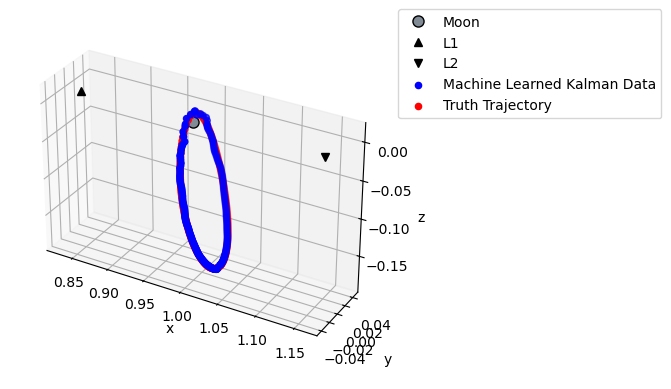

In [596]:
### Plot Orbits of Both Runge Kutta 4th Order and Supervised Learning: 
# %matplotlib widget
L1, L2 = [0.83691513, 0, 0], [1.15568217, 0, 0]
fig = plt.figure()
ax = plt.axes(projection = '3d')
    
ax.plot(1-mu, 0, 0, 'o', ms = 8, mec = 'k', mfc = '#808b96', label = 'Moon') # Plotting Moon
ax.plot(L1[0], L1[1], L1[2], '^', color = 'k', label = 'L1') # Plot L1
ax.plot(L2[0], L2[1], L2[2], 'v', color = 'k', label = 'L2')  
ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], label = 'Machine Learned Kalman Data', color = 'blue') # Machine Learning Trajectory train on EKF
ax.scatter(real_traj[:,0], real_traj[:,1], real_traj[:,2], label = "Truth Trajectory", color = 'red') # Truth Trajectory

# Set Axes Label
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
ax.set_aspect('equal')
plt.show()

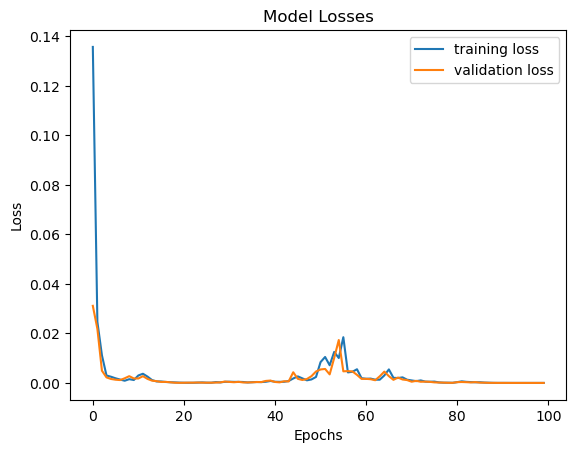

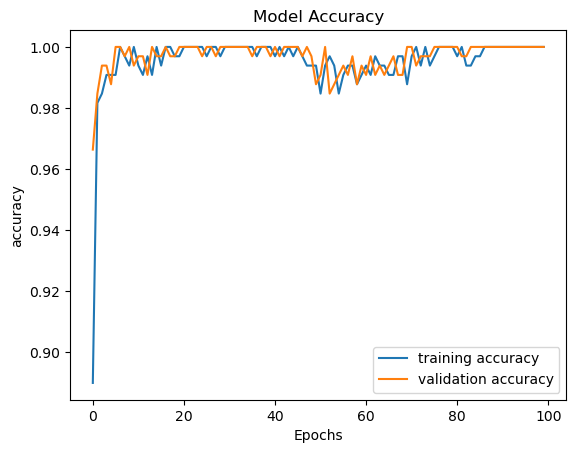

In [597]:
# Plot Graphs: 
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()